# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

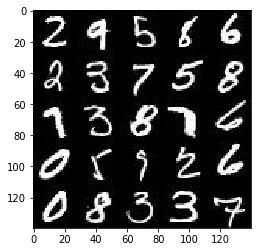

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

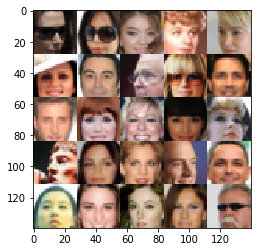

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14x14x256

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    width = data_shape[1]
    height = data_shape[2]
    out_channel_num = data_shape[3]
    input_real, input_z, lr = model_inputs(width, height, out_channel_num, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_num)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    print_every = 10
    show_every = 100
    num_image_show = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2.0
                
                steps += 1
                # Random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, num_image_show, input_z, out_channel_num, data_image_mode)
                


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.0078 Generator Loss: 7.6704
Epoch 0/2... Discriminator Loss: 0.1759 Generator Loss: 18.0548
Epoch 0/2... Discriminator Loss: 0.2313 Generator Loss: 9.5188
Epoch 0/2... Discriminator Loss: 4.0045 Generator Loss: 0.5414
Epoch 0/2... Discriminator Loss: 0.0047 Generator Loss: 7.8213
Epoch 0/2... Discriminator Loss: 0.0055 Generator Loss: 5.6418
Epoch 0/2... Discriminator Loss: 2.5827 Generator Loss: 1.9074
Epoch 0/2... Discriminator Loss: 0.3855 Generator Loss: 3.9955
Epoch 0/2... Discriminator Loss: 3.6685 Generator Loss: 5.5707
Epoch 0/2... Discriminator Loss: 1.1523 Generator Loss: 2.7188


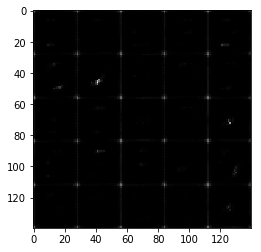

Epoch 0/2... Discriminator Loss: 1.2378 Generator Loss: 0.6659
Epoch 0/2... Discriminator Loss: 1.2128 Generator Loss: 0.8033
Epoch 0/2... Discriminator Loss: 0.9559 Generator Loss: 1.0692
Epoch 0/2... Discriminator Loss: 1.5756 Generator Loss: 2.9322
Epoch 0/2... Discriminator Loss: 1.1287 Generator Loss: 1.0090
Epoch 0/2... Discriminator Loss: 1.2565 Generator Loss: 1.6758
Epoch 0/2... Discriminator Loss: 0.9885 Generator Loss: 0.8855
Epoch 0/2... Discriminator Loss: 1.1368 Generator Loss: 1.3872
Epoch 0/2... Discriminator Loss: 1.2469 Generator Loss: 0.6940
Epoch 0/2... Discriminator Loss: 2.0095 Generator Loss: 0.2743


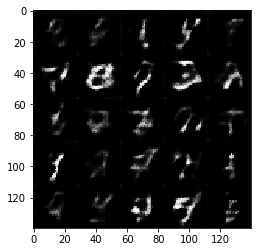

Epoch 0/2... Discriminator Loss: 0.9541 Generator Loss: 0.9502
Epoch 0/2... Discriminator Loss: 1.1866 Generator Loss: 0.7058
Epoch 0/2... Discriminator Loss: 1.1384 Generator Loss: 1.0694
Epoch 0/2... Discriminator Loss: 1.0431 Generator Loss: 0.8365
Epoch 0/2... Discriminator Loss: 1.1181 Generator Loss: 0.9381
Epoch 0/2... Discriminator Loss: 1.2537 Generator Loss: 1.5562
Epoch 0/2... Discriminator Loss: 1.3708 Generator Loss: 1.5704
Epoch 0/2... Discriminator Loss: 1.0561 Generator Loss: 1.0008
Epoch 0/2... Discriminator Loss: 1.0837 Generator Loss: 1.3971
Epoch 0/2... Discriminator Loss: 1.1415 Generator Loss: 1.0924


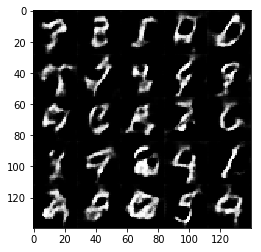

Epoch 0/2... Discriminator Loss: 1.2030 Generator Loss: 0.5647
Epoch 0/2... Discriminator Loss: 1.2291 Generator Loss: 0.5969
Epoch 0/2... Discriminator Loss: 1.1632 Generator Loss: 0.6316
Epoch 0/2... Discriminator Loss: 1.1548 Generator Loss: 0.7697
Epoch 0/2... Discriminator Loss: 1.2904 Generator Loss: 0.5828
Epoch 0/2... Discriminator Loss: 1.0431 Generator Loss: 1.0007
Epoch 0/2... Discriminator Loss: 1.2378 Generator Loss: 0.5776
Epoch 0/2... Discriminator Loss: 1.3721 Generator Loss: 0.4149
Epoch 0/2... Discriminator Loss: 1.3473 Generator Loss: 0.5028
Epoch 0/2... Discriminator Loss: 1.0688 Generator Loss: 1.2807


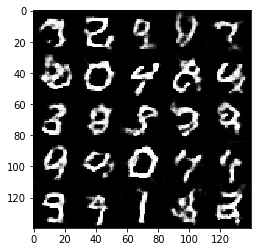

Epoch 0/2... Discriminator Loss: 1.1074 Generator Loss: 0.7044
Epoch 0/2... Discriminator Loss: 1.1547 Generator Loss: 0.7887
Epoch 0/2... Discriminator Loss: 1.4245 Generator Loss: 0.4939
Epoch 0/2... Discriminator Loss: 1.1946 Generator Loss: 0.5758
Epoch 0/2... Discriminator Loss: 1.0590 Generator Loss: 0.9870
Epoch 0/2... Discriminator Loss: 1.2776 Generator Loss: 0.5723
Epoch 0/2... Discriminator Loss: 0.9732 Generator Loss: 1.1696
Epoch 0/2... Discriminator Loss: 1.1510 Generator Loss: 1.0316
Epoch 0/2... Discriminator Loss: 1.2569 Generator Loss: 1.7817
Epoch 0/2... Discriminator Loss: 1.2054 Generator Loss: 0.5073


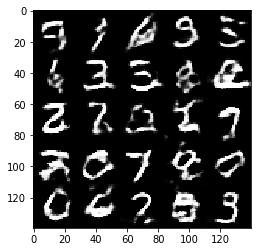

Epoch 0/2... Discriminator Loss: 0.8727 Generator Loss: 1.5831
Epoch 0/2... Discriminator Loss: 1.3618 Generator Loss: 1.9038
Epoch 0/2... Discriminator Loss: 0.9924 Generator Loss: 1.2000
Epoch 0/2... Discriminator Loss: 1.1157 Generator Loss: 1.6210
Epoch 0/2... Discriminator Loss: 0.9076 Generator Loss: 1.0991
Epoch 0/2... Discriminator Loss: 0.9115 Generator Loss: 1.3651
Epoch 0/2... Discriminator Loss: 1.0256 Generator Loss: 0.6907
Epoch 0/2... Discriminator Loss: 1.0740 Generator Loss: 1.1827
Epoch 0/2... Discriminator Loss: 1.2536 Generator Loss: 0.4763
Epoch 0/2... Discriminator Loss: 1.2397 Generator Loss: 1.6385


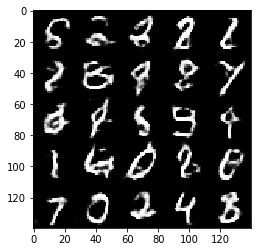

Epoch 0/2... Discriminator Loss: 1.0909 Generator Loss: 0.6388
Epoch 0/2... Discriminator Loss: 1.1284 Generator Loss: 1.7033
Epoch 0/2... Discriminator Loss: 0.9520 Generator Loss: 0.9979
Epoch 0/2... Discriminator Loss: 0.9009 Generator Loss: 0.9254
Epoch 0/2... Discriminator Loss: 0.9691 Generator Loss: 0.9843
Epoch 0/2... Discriminator Loss: 1.0982 Generator Loss: 0.7953
Epoch 0/2... Discriminator Loss: 1.4602 Generator Loss: 0.3666
Epoch 0/2... Discriminator Loss: 0.9827 Generator Loss: 1.1781
Epoch 0/2... Discriminator Loss: 1.1480 Generator Loss: 0.5694
Epoch 0/2... Discriminator Loss: 1.6443 Generator Loss: 0.3207


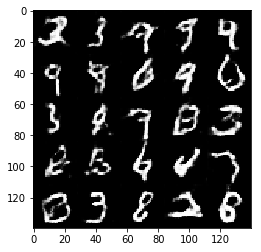

Epoch 0/2... Discriminator Loss: 1.1893 Generator Loss: 0.5914
Epoch 0/2... Discriminator Loss: 1.0232 Generator Loss: 1.0972
Epoch 0/2... Discriminator Loss: 1.0701 Generator Loss: 0.6804
Epoch 0/2... Discriminator Loss: 1.3387 Generator Loss: 0.4450
Epoch 0/2... Discriminator Loss: 1.3843 Generator Loss: 0.4843
Epoch 0/2... Discriminator Loss: 0.9909 Generator Loss: 0.6826
Epoch 0/2... Discriminator Loss: 1.3417 Generator Loss: 0.4207
Epoch 0/2... Discriminator Loss: 0.9172 Generator Loss: 0.9700
Epoch 0/2... Discriminator Loss: 0.9690 Generator Loss: 1.4569
Epoch 0/2... Discriminator Loss: 0.6626 Generator Loss: 1.4706


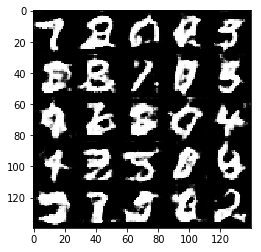

Epoch 0/2... Discriminator Loss: 1.1668 Generator Loss: 0.5282
Epoch 0/2... Discriminator Loss: 1.1899 Generator Loss: 0.5837
Epoch 0/2... Discriminator Loss: 1.0034 Generator Loss: 1.6063
Epoch 0/2... Discriminator Loss: 1.9714 Generator Loss: 0.2088
Epoch 0/2... Discriminator Loss: 1.1376 Generator Loss: 0.5997
Epoch 0/2... Discriminator Loss: 0.9191 Generator Loss: 1.3314
Epoch 0/2... Discriminator Loss: 0.9657 Generator Loss: 1.1875
Epoch 0/2... Discriminator Loss: 1.1895 Generator Loss: 0.5414
Epoch 0/2... Discriminator Loss: 1.1885 Generator Loss: 0.5986
Epoch 0/2... Discriminator Loss: 1.1544 Generator Loss: 0.6137


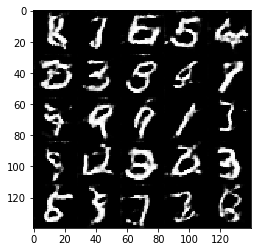

Epoch 0/2... Discriminator Loss: 0.9074 Generator Loss: 1.0572
Epoch 0/2... Discriminator Loss: 0.8890 Generator Loss: 1.3092
Epoch 0/2... Discriminator Loss: 1.1581 Generator Loss: 1.9130
Epoch 1/2... Discriminator Loss: 1.1177 Generator Loss: 0.6446
Epoch 1/2... Discriminator Loss: 0.8362 Generator Loss: 1.1293
Epoch 1/2... Discriminator Loss: 1.1017 Generator Loss: 1.3619
Epoch 1/2... Discriminator Loss: 0.9669 Generator Loss: 0.7156
Epoch 1/2... Discriminator Loss: 1.0434 Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.0198 Generator Loss: 0.7593
Epoch 1/2... Discriminator Loss: 0.9382 Generator Loss: 0.9415


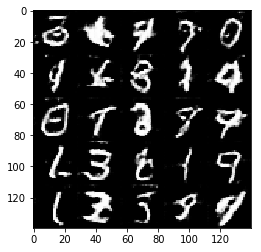

Epoch 1/2... Discriminator Loss: 1.3212 Generator Loss: 0.4355
Epoch 1/2... Discriminator Loss: 1.1704 Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 1.1331 Generator Loss: 0.5609
Epoch 1/2... Discriminator Loss: 1.2500 Generator Loss: 0.4991
Epoch 1/2... Discriminator Loss: 1.4419 Generator Loss: 0.5322
Epoch 1/2... Discriminator Loss: 1.0964 Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 0.8557 Generator Loss: 0.9209
Epoch 1/2... Discriminator Loss: 0.8505 Generator Loss: 0.9518
Epoch 1/2... Discriminator Loss: 0.8685 Generator Loss: 1.2920
Epoch 1/2... Discriminator Loss: 0.8996 Generator Loss: 0.7147


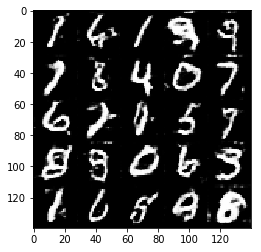

Epoch 1/2... Discriminator Loss: 0.7750 Generator Loss: 1.3162
Epoch 1/2... Discriminator Loss: 0.8365 Generator Loss: 1.1600
Epoch 1/2... Discriminator Loss: 2.3860 Generator Loss: 4.0201
Epoch 1/2... Discriminator Loss: 1.1601 Generator Loss: 1.2707
Epoch 1/2... Discriminator Loss: 1.1830 Generator Loss: 0.6969
Epoch 1/2... Discriminator Loss: 1.2233 Generator Loss: 0.6036
Epoch 1/2... Discriminator Loss: 0.9527 Generator Loss: 0.8033
Epoch 1/2... Discriminator Loss: 0.9437 Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 0.7984 Generator Loss: 0.9254
Epoch 1/2... Discriminator Loss: 0.9571 Generator Loss: 0.9658


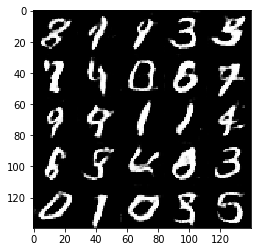

Epoch 1/2... Discriminator Loss: 0.9276 Generator Loss: 1.0021
Epoch 1/2... Discriminator Loss: 0.9624 Generator Loss: 0.9231
Epoch 1/2... Discriminator Loss: 0.9235 Generator Loss: 0.8930
Epoch 1/2... Discriminator Loss: 0.9978 Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 0.9772 Generator Loss: 1.1368
Epoch 1/2... Discriminator Loss: 1.0101 Generator Loss: 0.7478
Epoch 1/2... Discriminator Loss: 0.8993 Generator Loss: 1.4708
Epoch 1/2... Discriminator Loss: 1.0392 Generator Loss: 1.0236
Epoch 1/2... Discriminator Loss: 1.1578 Generator Loss: 0.5875
Epoch 1/2... Discriminator Loss: 1.0659 Generator Loss: 0.6336


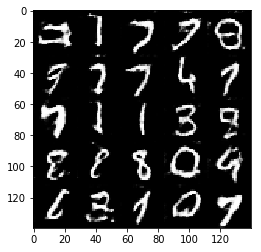

Epoch 1/2... Discriminator Loss: 0.7505 Generator Loss: 1.2622
Epoch 1/2... Discriminator Loss: 0.9817 Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 0.7439 Generator Loss: 1.0244
Epoch 1/2... Discriminator Loss: 0.9200 Generator Loss: 0.7954
Epoch 1/2... Discriminator Loss: 1.8091 Generator Loss: 2.8817
Epoch 1/2... Discriminator Loss: 0.9477 Generator Loss: 1.2450
Epoch 1/2... Discriminator Loss: 0.8939 Generator Loss: 1.1366
Epoch 1/2... Discriminator Loss: 1.3624 Generator Loss: 0.4417
Epoch 1/2... Discriminator Loss: 1.2224 Generator Loss: 0.5475
Epoch 1/2... Discriminator Loss: 1.7960 Generator Loss: 0.2389


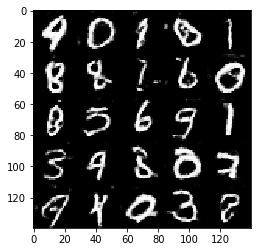

Epoch 1/2... Discriminator Loss: 1.3935 Generator Loss: 0.4146
Epoch 1/2... Discriminator Loss: 1.0584 Generator Loss: 0.7650
Epoch 1/2... Discriminator Loss: 0.8864 Generator Loss: 0.8453
Epoch 1/2... Discriminator Loss: 1.1052 Generator Loss: 0.6087
Epoch 1/2... Discriminator Loss: 1.1998 Generator Loss: 0.5105
Epoch 1/2... Discriminator Loss: 0.8708 Generator Loss: 1.6662
Epoch 1/2... Discriminator Loss: 0.6811 Generator Loss: 1.2642
Epoch 1/2... Discriminator Loss: 0.6121 Generator Loss: 1.2462
Epoch 1/2... Discriminator Loss: 1.0614 Generator Loss: 0.5941
Epoch 1/2... Discriminator Loss: 0.5861 Generator Loss: 1.2432


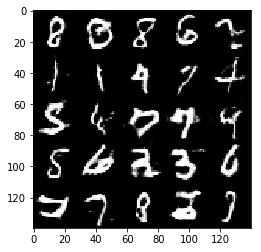

Epoch 1/2... Discriminator Loss: 0.5658 Generator Loss: 1.3575
Epoch 1/2... Discriminator Loss: 0.9294 Generator Loss: 0.9596
Epoch 1/2... Discriminator Loss: 0.9106 Generator Loss: 0.8931
Epoch 1/2... Discriminator Loss: 0.9378 Generator Loss: 2.1197
Epoch 1/2... Discriminator Loss: 1.1289 Generator Loss: 0.6299
Epoch 1/2... Discriminator Loss: 0.7914 Generator Loss: 1.0998
Epoch 1/2... Discriminator Loss: 0.9822 Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 1.1758 Generator Loss: 0.5536
Epoch 1/2... Discriminator Loss: 0.4942 Generator Loss: 1.4589
Epoch 1/2... Discriminator Loss: 0.5989 Generator Loss: 1.2037


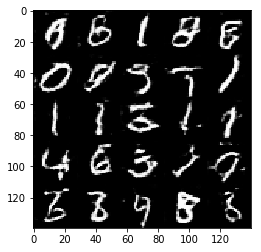

Epoch 1/2... Discriminator Loss: 1.0120 Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.3373 Generator Loss: 0.4648
Epoch 1/2... Discriminator Loss: 1.5140 Generator Loss: 0.3790
Epoch 1/2... Discriminator Loss: 0.6421 Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 0.6537 Generator Loss: 1.6693
Epoch 1/2... Discriminator Loss: 1.4032 Generator Loss: 0.4246
Epoch 1/2... Discriminator Loss: 0.9073 Generator Loss: 1.0943
Epoch 1/2... Discriminator Loss: 0.9693 Generator Loss: 0.6590
Epoch 1/2... Discriminator Loss: 0.4967 Generator Loss: 1.6775
Epoch 1/2... Discriminator Loss: 0.8599 Generator Loss: 1.3846


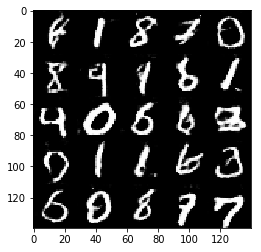

Epoch 1/2... Discriminator Loss: 1.0806 Generator Loss: 0.6749
Epoch 1/2... Discriminator Loss: 0.7995 Generator Loss: 0.9751
Epoch 1/2... Discriminator Loss: 1.0161 Generator Loss: 0.6631
Epoch 1/2... Discriminator Loss: 0.9357 Generator Loss: 1.0187
Epoch 1/2... Discriminator Loss: 1.1277 Generator Loss: 1.8633
Epoch 1/2... Discriminator Loss: 0.6380 Generator Loss: 1.2790
Epoch 1/2... Discriminator Loss: 0.6975 Generator Loss: 1.1823
Epoch 1/2... Discriminator Loss: 1.6604 Generator Loss: 0.2892
Epoch 1/2... Discriminator Loss: 0.6930 Generator Loss: 1.2034
Epoch 1/2... Discriminator Loss: 0.8319 Generator Loss: 1.4489


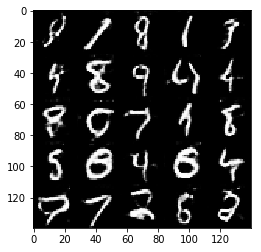

Epoch 1/2... Discriminator Loss: 0.6922 Generator Loss: 1.1692
Epoch 1/2... Discriminator Loss: 0.5889 Generator Loss: 1.4130
Epoch 1/2... Discriminator Loss: 0.8208 Generator Loss: 1.6482
Epoch 1/2... Discriminator Loss: 1.9969 Generator Loss: 0.2757
Epoch 1/2... Discriminator Loss: 0.4800 Generator Loss: 1.4464
Epoch 1/2... Discriminator Loss: 0.4237 Generator Loss: 1.6611
Epoch 1/2... Discriminator Loss: 0.6405 Generator Loss: 1.0895


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.1256 Generator Loss: 18.4478
Epoch 0/1... Discriminator Loss: 0.0017 Generator Loss: 17.0989
Epoch 0/1... Discriminator Loss: 0.0850 Generator Loss: 11.2141
Epoch 0/1... Discriminator Loss: 0.1122 Generator Loss: 11.2179
Epoch 0/1... Discriminator Loss: 0.0573 Generator Loss: 4.0760
Epoch 0/1... Discriminator Loss: 0.0913 Generator Loss: 3.5760
Epoch 0/1... Discriminator Loss: 0.7924 Generator Loss: 1.7016
Epoch 0/1... Discriminator Loss: 0.6991 Generator Loss: 8.0664
Epoch 0/1... Discriminator Loss: 0.1804 Generator Loss: 2.9465
Epoch 0/1... Discriminator Loss: 0.3416 Generator Loss: 1.9103


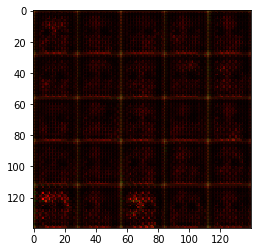

Epoch 0/1... Discriminator Loss: 1.0838 Generator Loss: 0.8141
Epoch 0/1... Discriminator Loss: 0.4187 Generator Loss: 10.8392
Epoch 0/1... Discriminator Loss: 0.5466 Generator Loss: 1.2743
Epoch 0/1... Discriminator Loss: 0.0788 Generator Loss: 4.6423
Epoch 0/1... Discriminator Loss: 0.2184 Generator Loss: 3.2612
Epoch 0/1... Discriminator Loss: 0.2037 Generator Loss: 3.7008
Epoch 0/1... Discriminator Loss: 2.8365 Generator Loss: 7.3238
Epoch 0/1... Discriminator Loss: 1.3497 Generator Loss: 0.5343
Epoch 0/1... Discriminator Loss: 1.8696 Generator Loss: 0.3255
Epoch 0/1... Discriminator Loss: 1.6684 Generator Loss: 0.4665


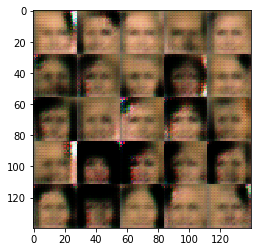

Epoch 0/1... Discriminator Loss: 2.1358 Generator Loss: 0.2467
Epoch 0/1... Discriminator Loss: 1.5318 Generator Loss: 1.0513
Epoch 0/1... Discriminator Loss: 1.4216 Generator Loss: 0.8843
Epoch 0/1... Discriminator Loss: 1.0157 Generator Loss: 1.0802
Epoch 0/1... Discriminator Loss: 0.9721 Generator Loss: 1.5275
Epoch 0/1... Discriminator Loss: 1.8411 Generator Loss: 3.4074
Epoch 0/1... Discriminator Loss: 1.2303 Generator Loss: 0.7036
Epoch 0/1... Discriminator Loss: 1.4027 Generator Loss: 0.8574
Epoch 0/1... Discriminator Loss: 1.4107 Generator Loss: 0.3774
Epoch 0/1... Discriminator Loss: 1.0986 Generator Loss: 1.1452


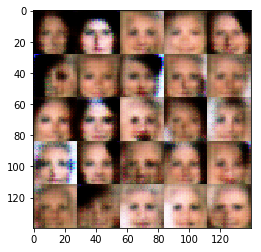

Epoch 0/1... Discriminator Loss: 1.0331 Generator Loss: 1.0007
Epoch 0/1... Discriminator Loss: 0.7890 Generator Loss: 1.0402
Epoch 0/1... Discriminator Loss: 1.1238 Generator Loss: 0.6781
Epoch 0/1... Discriminator Loss: 1.0762 Generator Loss: 1.7837
Epoch 0/1... Discriminator Loss: 1.1129 Generator Loss: 1.2855
Epoch 0/1... Discriminator Loss: 1.4781 Generator Loss: 0.5168
Epoch 0/1... Discriminator Loss: 1.3325 Generator Loss: 1.3640
Epoch 0/1... Discriminator Loss: 0.4447 Generator Loss: 1.8986
Epoch 0/1... Discriminator Loss: 1.0397 Generator Loss: 1.7750
Epoch 0/1... Discriminator Loss: 1.2817 Generator Loss: 1.5060


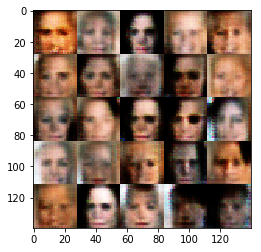

Epoch 0/1... Discriminator Loss: 1.2033 Generator Loss: 2.5060
Epoch 0/1... Discriminator Loss: 0.6431 Generator Loss: 1.1220
Epoch 0/1... Discriminator Loss: 1.0604 Generator Loss: 1.0629
Epoch 0/1... Discriminator Loss: 0.6614 Generator Loss: 1.5184
Epoch 0/1... Discriminator Loss: 0.9067 Generator Loss: 1.4317
Epoch 0/1... Discriminator Loss: 1.0010 Generator Loss: 0.6788
Epoch 0/1... Discriminator Loss: 0.7671 Generator Loss: 1.3176
Epoch 0/1... Discriminator Loss: 0.8707 Generator Loss: 2.3765
Epoch 0/1... Discriminator Loss: 1.2339 Generator Loss: 0.6574
Epoch 0/1... Discriminator Loss: 1.0439 Generator Loss: 1.5914


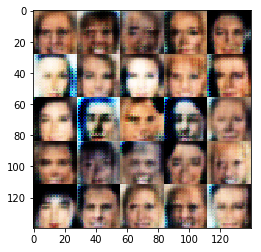

Epoch 0/1... Discriminator Loss: 1.1139 Generator Loss: 1.9307
Epoch 0/1... Discriminator Loss: 1.6955 Generator Loss: 0.4144
Epoch 0/1... Discriminator Loss: 1.0460 Generator Loss: 1.0324
Epoch 0/1... Discriminator Loss: 0.9969 Generator Loss: 0.6757
Epoch 0/1... Discriminator Loss: 2.0011 Generator Loss: 0.2219
Epoch 0/1... Discriminator Loss: 1.1889 Generator Loss: 0.5422
Epoch 0/1... Discriminator Loss: 1.2628 Generator Loss: 0.6218
Epoch 0/1... Discriminator Loss: 1.0172 Generator Loss: 0.6709
Epoch 0/1... Discriminator Loss: 0.8505 Generator Loss: 1.6049
Epoch 0/1... Discriminator Loss: 1.3113 Generator Loss: 1.1108


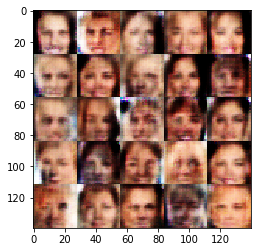

Epoch 0/1... Discriminator Loss: 0.9502 Generator Loss: 1.2857
Epoch 0/1... Discriminator Loss: 1.1887 Generator Loss: 0.8471
Epoch 0/1... Discriminator Loss: 0.9082 Generator Loss: 1.4578
Epoch 0/1... Discriminator Loss: 1.3301 Generator Loss: 1.9721
Epoch 0/1... Discriminator Loss: 1.5585 Generator Loss: 0.3128
Epoch 0/1... Discriminator Loss: 1.3420 Generator Loss: 2.7288
Epoch 0/1... Discriminator Loss: 0.7176 Generator Loss: 1.5385
Epoch 0/1... Discriminator Loss: 1.2024 Generator Loss: 0.5966
Epoch 0/1... Discriminator Loss: 1.4932 Generator Loss: 0.3967
Epoch 0/1... Discriminator Loss: 1.2656 Generator Loss: 0.5845


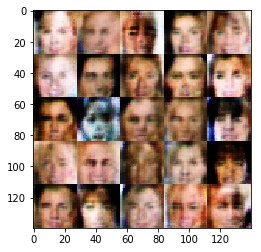

Epoch 0/1... Discriminator Loss: 1.1482 Generator Loss: 0.6716
Epoch 0/1... Discriminator Loss: 1.2149 Generator Loss: 0.6071
Epoch 0/1... Discriminator Loss: 1.4260 Generator Loss: 0.6534
Epoch 0/1... Discriminator Loss: 0.9980 Generator Loss: 1.0115
Epoch 0/1... Discriminator Loss: 1.0939 Generator Loss: 0.7510
Epoch 0/1... Discriminator Loss: 2.8585 Generator Loss: 2.6638
Epoch 0/1... Discriminator Loss: 1.0839 Generator Loss: 0.6683
Epoch 0/1... Discriminator Loss: 1.3296 Generator Loss: 0.4558
Epoch 0/1... Discriminator Loss: 1.4068 Generator Loss: 0.6610
Epoch 0/1... Discriminator Loss: 0.9279 Generator Loss: 1.0205


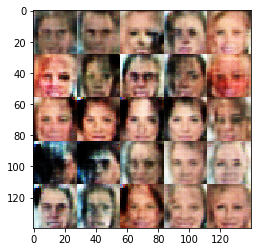

Epoch 0/1... Discriminator Loss: 0.9120 Generator Loss: 0.7894
Epoch 0/1... Discriminator Loss: 1.6429 Generator Loss: 0.4345
Epoch 0/1... Discriminator Loss: 1.2304 Generator Loss: 0.5613
Epoch 0/1... Discriminator Loss: 1.2402 Generator Loss: 0.5298
Epoch 0/1... Discriminator Loss: 1.2743 Generator Loss: 0.7414
Epoch 0/1... Discriminator Loss: 1.3530 Generator Loss: 0.4231
Epoch 0/1... Discriminator Loss: 1.8974 Generator Loss: 1.9018
Epoch 0/1... Discriminator Loss: 2.1200 Generator Loss: 0.1761
Epoch 0/1... Discriminator Loss: 1.2032 Generator Loss: 0.6733
Epoch 0/1... Discriminator Loss: 1.2712 Generator Loss: 0.6900


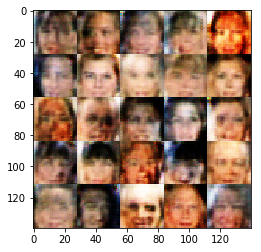

Epoch 0/1... Discriminator Loss: 1.0327 Generator Loss: 1.1280
Epoch 0/1... Discriminator Loss: 1.0441 Generator Loss: 0.7381
Epoch 0/1... Discriminator Loss: 1.7982 Generator Loss: 4.9288
Epoch 0/1... Discriminator Loss: 0.9007 Generator Loss: 0.7809
Epoch 0/1... Discriminator Loss: 1.3413 Generator Loss: 0.4058
Epoch 0/1... Discriminator Loss: 1.0498 Generator Loss: 0.6737
Epoch 0/1... Discriminator Loss: 1.4234 Generator Loss: 0.4833
Epoch 0/1... Discriminator Loss: 1.3116 Generator Loss: 1.1325
Epoch 0/1... Discriminator Loss: 1.2040 Generator Loss: 0.6438
Epoch 0/1... Discriminator Loss: 1.3723 Generator Loss: 0.7615


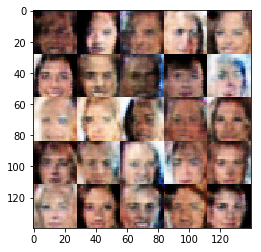

Epoch 0/1... Discriminator Loss: 1.3524 Generator Loss: 0.5078
Epoch 0/1... Discriminator Loss: 1.8852 Generator Loss: 2.1002
Epoch 0/1... Discriminator Loss: 1.3251 Generator Loss: 0.4949
Epoch 0/1... Discriminator Loss: 1.1181 Generator Loss: 1.2017
Epoch 0/1... Discriminator Loss: 1.1414 Generator Loss: 0.7152
Epoch 0/1... Discriminator Loss: 1.2868 Generator Loss: 0.8601
Epoch 0/1... Discriminator Loss: 1.1020 Generator Loss: 0.8840
Epoch 0/1... Discriminator Loss: 1.7966 Generator Loss: 0.2198
Epoch 0/1... Discriminator Loss: 0.8759 Generator Loss: 0.8547
Epoch 0/1... Discriminator Loss: 1.1836 Generator Loss: 0.7095


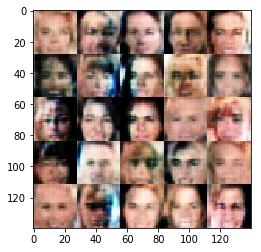

Epoch 0/1... Discriminator Loss: 1.1479 Generator Loss: 0.7586
Epoch 0/1... Discriminator Loss: 1.2000 Generator Loss: 0.5269
Epoch 0/1... Discriminator Loss: 1.3154 Generator Loss: 0.6443
Epoch 0/1... Discriminator Loss: 1.4055 Generator Loss: 0.6664
Epoch 0/1... Discriminator Loss: 1.4995 Generator Loss: 0.3953
Epoch 0/1... Discriminator Loss: 1.6945 Generator Loss: 0.2963
Epoch 0/1... Discriminator Loss: 1.0819 Generator Loss: 1.4279
Epoch 0/1... Discriminator Loss: 1.2040 Generator Loss: 0.7510
Epoch 0/1... Discriminator Loss: 1.1495 Generator Loss: 0.6052
Epoch 0/1... Discriminator Loss: 1.2341 Generator Loss: 0.5297


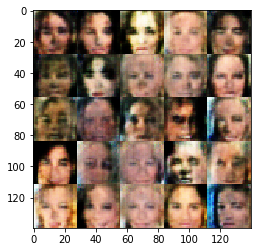

Epoch 0/1... Discriminator Loss: 1.2198 Generator Loss: 0.5782


KeyboardInterrupt: 

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.